In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
from glob import glob
import pickle
import time
import collections
from types import SimpleNamespace as SN
import yaml
import json

import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from smac.env import StarCraft2Env
import smac.env.starcraft2.maps as maps

from functools import partial
from components.episode_buffer import EpisodeBatch

In [3]:
# device
use_cuda = True
load_models = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print("device:", device)

device: cuda


In [59]:
# compare training performance
def load_json(path):
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON file {path}: {e}")

class Experiment():
    def __init__(self, path, id_major=0):
        
        self.path = path
        self.id_major = id_major
        self.id_minor = int(self.path.split(os.sep)[-1])     
        self.id = f"{self.id_major}.{self.id_minor}"
        
        # load run and config   
        info, config = [os.path.join(path, f"{f}.json") for f in ['info', 'config']]
        self.config = load_json(config)        
        
        # extract metadata
        self.name = self.config['name']
        self.map_name = self.config["map_name"]
        
        # load info
        self.info = load_json(info)
        
        # parse info
        self.results = {}
        for k, v in self.info.items():
            if isinstance(v[0], dict):
                if "value" in v[0].keys():                
                    self.results[k] = np.array([vv["value"] for vv in v])
                #elif list(v[0].keys()) == ['py/reduce']:
                #    print(v[0]["py/reduce"])
                else:
                    print(f"Unexpected key: '{k}'")
            else:
                self.results[k] = np.array(v)  
                
def load_experiments(result_dirs):
    experiments = []
    maps = {}
    for i, r in enumerate(result_dirs):    
        if not os.path.exists(r):
            #raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), r)
            print(f"results directory '{r}' not found")

        for d in glob(f"{r}/*"):
            if '_sources' not in d: # ignore _sources directory
                try:
                    e = Experiment(d, id_major=i)
                    #print(e.path)
                    experiments.append(e)
                    if e.map_name not in maps:
                        maps[e.map_name] = [e.name]
                    elif e.name not in maps[e.map_name]:
                        maps[e.map_name].append(e.name)
                except Exception as e:
                    print(f"Error loading results directory: {d}, error: {e}")

    print("=============================================")                
#     for e in sorted(experiments, key=lambda e: e.id):
#          print(e)    
    for k, v in maps.items():
        print(f"map: {k}")
        for n in v:
            print(f"  -- {n}")
        
    return experiments     

def group_experiments(experiments, group_names, map_name, only_common_keys=False):
    groups = {}
    group_experiments = []
    for g in group_names:
        g_exp = [e for e in experiments if e.name == g and e.map_name == map_name]        
        group_experiments += g_exp
        if len(g_exp) > 0: # exclude groups with no experiments
            groups[g] = g_exp
    for k, v in groups.items():
        print(f"group '{k}': {len(v)} episodes")

    # find comparable keys
    group_keys = []
    for k, v in groups.items():
        g_keys = []
        for e in v:
            g_keys += list(e.results.keys())                
        group_keys.append(set(g_keys))   
    if only_common_keys:
        valid_keys = group_keys[0].intersection(*group_keys[1:]) if len(group_keys) > 1 else group_keys[0]    
    else:
        valid_keys = list(set([k for g in group_keys for k in g]))    
    valid_keys = [k for k in valid_keys if not k.endswith("_T")]

    # find experiment lengths
    experiment_lengths = set([(e.id, len(e.results[k])) for e in group_experiments for k in valid_keys if k in e.results])
    experiment_lengths = sorted(list(experiment_lengths), key=lambda e: e[1])
    experiment_length_frequency = {}
    for eid, n in experiment_lengths:
        if n not in experiment_length_frequency:
            experiment_length_frequency[n] = [eid]
        else:
            experiment_length_frequency[n].append(eid)
            
#     for k, v in experiment_length_frequency.items():
#         print(f"length: {k}, count: {len(v)}, ids: {v}")
#     min_n = min(sorted(list(experiment_length_frequency.keys())))
#     print(f"min_n: {min_n}")

    return groups, valid_keys

def compute_stats(groups, valid_keys):    
    stats = {}
    for k, v in groups.items():
        stats[k] = {}
        for vk in valid_keys:   
            r = [e.results[vk] for e in v if vk in e.results]     
            if len(r) > 0:
                min_n = min([len(x) for x in r])
                r = [x[:min_n] for x in r]                           

                stats[k][vk] = {} 

                a = np.stack(r)
                stats[k][vk]["values"] = a
                stats[k][vk]["mean"] = a.mean(axis=0)
                stats[k][vk]["std"] = a.std(axis=0)
                stats[k][vk]["min"] = a.min(axis=0)
                stats[k][vk]["max"] = a.max(axis=0)
                stats[k][vk]["median"] = np.median(a, axis=0)                
                stats[k][vk]["25pctl"] = np.percentile(a, 25, axis=0)
                stats[k][vk]["75pctl"] = np.percentile(a, 75, axis=0)

                vkt = vk + "_T"
                t = [e.results[vkt][:min_n] for e in v if vkt in e.results]            
                stats[k][vk]["mean_T"] = np.stack(t).mean(axis=0)
                
    return stats

def plot_group_stats(groups, valid_keys, stats, method, xlabel="T (s)", ylabels={}, selected_keys=None, include_bounds=True, title_prefix=""):    
    colors = {g:f"C{i}" for i, g in enumerate(groups.keys())}    
    nvar = len(selected_keys) if selected_keys else len(valid_keys)        
    fig, axes = plt.subplots(nvar, 1, squeeze=False, sharex=True, figsize=(15, 3 * nvar));  
    keys = selected_keys if selected_keys else valid_keys
    keys.sort()
    for i, v in enumerate(keys):             
        for g in groups.keys():
            if v in stats[g]:
                if method == "mean_std":
                    y = stats[g][v]["mean"]            
                    delta = stats[g][v]["std"]
                    ub = y + delta        
                    lb = y - delta
                elif method == "median_percentile":            
                    y = stats[g][v]["median"]
                    ub = stats[g][v]["75pctl"]        
                    lb = stats[g][v]["25pctl"]
                elif method == "mean_min_max":
                    y = stats[g][v]["mean"]
                    ub = stats[g][v]["max"]
                    lb = stats[g][v]["min"]
                else:
                    print(f"unrecognized method {method}")            
                x = stats[g][v]["mean_T"]
                axes[i, 0].plot(x, y, color=colors[g], label=g);
                if include_bounds:
                    axes[i, 0].fill_between(x, ub, lb, color=colors[g], alpha=0.3);
                axes[i, 0].set_title(f"{title_prefix} {v}");
                axes[i, 0].legend(loc=(1.05, 0.5));
                if v in ylabels:
                    axes[i, 0].set_ylabel(ylabels[v])
    plt.xlabel(xlabel)
    plt.tight_layout()
    return fig;

In [4]:
class Scenario():
    
    def __init__(self, pymarl_dir, map_name, alg_config, default_config="default.yaml", env_config="sc2.yaml"):
        
        self.pymarl_dir = pymarl_dir
        self.alg_config = alg_config
        self.env_config = env_config
        self.default_config = default_config
        
        self.args = self.load_args()     
        self.args.env_args["map_name"] = map_name
        self.env = StarCraft2Env(**self.args.env_args)
        
        self.info = self.env.get_env_info()
        self.info["map_name"] = self.env.map_name
        
        self.episodes = []
        
        self.nf_ally, self.nf_enemy, self.nf_other, self.nf_custom, self.ally_scheme, self.enemy_scheme, self.other_scheme, self.custom_scheme = self._get_state_scheme() 
        
        self.map_registry = {"3m": (32, 32)}
        
    def get_map_dims(self):                
        name = self.env.map_name
        assert name in self.map_registry, f"map '{name}' not in {self.map_registry}"
        return self.map_registry[name]
        
    def recursive_dict_update(self, d, u):
        for k, v in u.items():
            if isinstance(v, collections.Mapping):
                d[k] = self.recursive_dict_update(d.get(k, {}), v)
            else:
                d[k] = v
        return d    
        
    def load_args(self):
        configs = [f"src/config/{self.default_config}", f"src/config/envs/{self.env_config}", 
                   f"src/config/algs/{self.alg_config}"]
        config_dict = None        
        for c in configs:
            with open(os.path.join(self.pymarl_dir, c), 'r') as f:
                config = yaml.load(f, Loader=yaml.FullLoader)
                if not config_dict:
                    config_dict = config
                else:
                    config_dict = self.recursive_dict_update(config_dict, config)    

        return SN(**config_dict)
        
    def get_episode_index(self, f):
        return int(os.path.splitext(f)[0].split('_')[-1])
    
    def load_episodes(self, episode_dir, limit=None, verbose=False):        
        indices = set(self.get_episode_index(f) for f in glob(os.path.join(episode_dir, "*.pkl")))
        indices = sorted(list(indices))
        n_episodes = len(indices)
        indices = indices[:limit] if limit else indices

        episodes = [] # list of dictionaries of tensors
        
        for i in indices:
            fname = os.path.join(episode_dir, f"episode_{i:06}.pkl")    
            with open(fname, 'rb') as f:            
                episodes.append(pickle.load(f))     
                if verbose:
                    print(f"loading {100 * len(episodes)/len(indices):.2f} %", end='\r')
        self.episodes = episodes
        
        if verbose:
            print(f"loaded {len(self.episodes)}/{n_episodes} episodes")                
            
    
    def get_state_scheme(self, other_features=False, custom_features=False):   

        #state_size_max = self.env.get_state_size()
        #state_size_min = self.get_min_state_size()
        #state_size = state.size()[-1]
        #assert state_size in [state_size_max, state_size_min], f"expected state tensor with final dimension {state_size_max} or {state_size_min}"          
                
        nf_ally, nf_enemy, nf_other, nf_custom, scheme_ally, scheme_enemy, scheme_other, scheme_custom = self._get_state_scheme()
                 
        scheme = {}
        for a in range(self.env.n_agents):                            
            for k, v in scheme_ally.items():                            
                idx = a * nf_ally + v
                name = f"ally_{a}_{k}"
                scheme[name] = idx

        for a in range(self.env.n_enemies):                            
            for k, v in scheme_enemy.items():                            
                idx = self.env.n_agents * nf_ally + a * nf_enemy + v
                name = f"enemy_{a}_{k}"
                scheme[name] = idx

        if other_features:
            for k, v in scheme_other.items():
                idx = self.env.n_agents * nf_ally + self.env.n_enemies * nf_enemy + v
                scheme[k] = idx
                
        if custom_features:
            n = len(scheme)
            for k, v in scheme_custom.items():                            
                idx = n + v            
                scheme[k] = idx
            
        return scheme        
                        
    def _get_state_scheme(self):

        nf_ally = 4 + self.env.shield_bits_ally + self.env.unit_type_bits
        nf_enemy = 3 + self.env.shield_bits_enemy + self.env.unit_type_bits        
        
        # allies
        ally_scheme = {"health": 0, "cooldown": 1, "x": 2, "y": 3}
        idx = 4
        for i in range(self.env.shield_bits_ally):
            ally_scheme[f"ally_shield_{i}"] = idx; idx += 1
        for i in range(self.env.unit_type_bits):
            ally_scheme[f"ally_type_{i}"] = idx; idx += 1

        # enemies
        enemy_scheme = {"health": 0, "x": 1, "y": 2}
        idx = 3
        for i in range(self.env.shield_bits_enemy):
            enemy_scheme[f"ally_shield_{i}"] = idx; idx += 1
        for i in range(self.env.unit_type_bits):
            enemy_scheme[f"enemy_type_{i}"] = idx; idx += 1
        
        #other
        nf_other = 0
        other_scheme = {}
        if self.env.state_last_action:
            nf_other = self.env.n_agents * self.env.n_actions
            for i in range(self.env.n_agents):
                for j in range(self.env.n_actions):
                    other_scheme[f"agent_{i}_action_{j}"] = i * self.env.n_actions + j                    
        if self.env.state_timestep_number:
            nf_other += 1
            other_scheme["timestep"] = len(other_scheme) + 1
            
        # custom
        nf_custom = 2
        custom_scheme = {"reward":0, "term_signal":1}
        
            
        return nf_ally, nf_enemy, nf_other, nf_custom, ally_scheme, enemy_scheme, other_scheme, custom_scheme
    
    def get_obs_scheme(self):        
        move_feats_dim = np.product(self.env.get_obs_move_feats_size())
        enemy_feats_dim = np.product(self.env.get_obs_enemy_feats_size())
        ally_feats_dim = np.product(self.env.get_obs_ally_feats_size())
        own_feats_dim = np.product(self.env.get_obs_own_feats_size())
        
        #print(move_feats_dim, enemy_feats_dim, ally_feats_dim, own_feats_dim)
        
        scheme = {}
        obs_dim = move_feats_dim + enemy_feats_dim + ally_feats_dim + own_feats_dim
        fidx = -1
        for a in range(self.env.n_agents):
            
            # movement features
            for d in ["NORTH", "SOUTH", "EAST", "WEST"]:
                fname = f"agent_{a}_move_{d}"; fidx += 1; scheme[fname] = fidx
                                            
            if self.env.obs_pathing_grid:
                for i in range(self.env.n_obs_pathing):                    
                    fname = f"agent_{a}_pathing_{i}"; fidx += 1; scheme[fname] = fidx
                
            if self.env.obs_terrain_height:
                idx = fidx
                for i in range(idx, move_feats_dim):
                    fname = f"agent_{a}_terrain_{i}"; fidx += 1; scheme[fname] = fidx 
                    
            # enemy features
            for e in range(self.env.n_enemies):                                   
                fname = f"agent_{a}_enemy_{e}_in_range"; fidx += 1; scheme[fname] = fidx
                fname = f"agent_{a}_enemy_{e}_distance";  fidx += 1; scheme[fname] = fidx
                fname = f"agent_{a}_enemy_{e}_relative_x";  fidx += 1; scheme[fname] = fidx
                fname = f"agent_{a}_enemy_{e}_relative_y";  fidx += 1; scheme[fname] = fidx
                
                if self.env.obs_all_health:
                    fname = f"agent_{a}_enemy_{e}_health";  fidx += 1; scheme[fname] = fidx
                    if self.env.shield_bits_enemy > 0:
                        fname = f"agent_{a}_enemy_{e}_shield";  fidx += 1; scheme[fname] = fidx

                if self.env.unit_type_bits > 0:
                    for i in range(self.env.unit_type_bits):
                        fname = f"agent_{a}_enemy_{e}_type_{i}"; fidx += 1; scheme[fname] = fidx
                
            # ally features
            allies = [x for x in range(self.env.n_agents) if x != a]
            for y in allies:
                fname = f"agent_{a}_ally_{y}_visible"; fidx += 1; scheme[fname] = fidx
                fname = f"agent_{a}_ally_{y}_distance"; fidx += 1; scheme[fname] = fidx
                fname = f"agent_{a}_ally_{y}_relative_x"; fidx += 1; scheme[fname] = fidx
                fname = f"agent_{a}_ally_{y}_relative_y"; fidx += 1; scheme[fname] = fidx
                
                if self.env.obs_all_health:
                    fname = f"agent_{a}_ally_{y}_health"; fidx += 1; scheme[fname] = fidx                
                    if self.env.shield_bits_ally > 0:
                        fname = f"agent_{a}_ally_{y}_shield"; fidx += 1; scheme[fname] = fidx
                        
                if self.env.unit_type_bits > 0:
                    for i in range(self.env.unit_type_bits):
                        fname = f"agent_{a}_ally_{y}_type_{i}"; fidx += 1; scheme[fname] = fidx
            
                if self.env.obs_last_action:
                    fname = f"agent_{a}_ally_{y}_last_action"; fidx += 1; scheme[fname] = fidx

            # own features
            if self.env.obs_own_health:
                fname = f"agent_{a}_health"; fidx += 1; scheme[fname] = fidx                
            if self.env.obs_timestep_number:
                fname = f"timestep"; fidx += 1; scheme[fname] = fidx            

            if self.env.unit_type_bits > 0:
                for i in range(self.env.unit_type_bits):
                    fname = f"agent_{a}_type_{i}"; fidx += 1; scheme[fname] = fidx
                            
            
        # available actions
        action_map = {v:k for v, k in enumerate(["no-op", "stop", "move_north", "move_south", "move_east", "move_west"])}
        idx = len(action_map)        
        for i in range(self.env.n_enemies):
            action_map[idx + i] = f"engage_enemy_{i}"
            
        for i in range(self.env.n_agents):
            for j in range(self.env.n_actions):
                k = action_map[j]
                fname = f"agent_{i}_action_{k}_available"; fidx += 1; scheme[fname] = fidx            
        
        return scheme
                                                    
    def get_min_state_size(self):
        return self.env.n_agents * self.nf_ally + self.env.n_enemies * self.nf_enemy
    
    def get_episode_vars(self, ep):

        if isinstance(ep, int): 
            assert len(self.episodes) > 0, "no episodes loaded"
            assert ep < len(self.episodes), f"episode list of length {len(self.episodes)} does not contain index {ep}"     
            ep = self.episodes[ep]   
                
        # per-agent quantities
        obs = ep["obs"][:, :-1, :] # observations
        aa = ep["avail_actions"][:, :-1, :].float() # available actions                      
        actions = ep["actions_onehot"][:, :-1, :] # actions taken
        
        # flatten per-agent quantities
        nbatch, ntimesteps, _ , _ = obs.size()        
        obs = obs.view((nbatch, ntimesteps, -1))        
        aa = aa.view((nbatch, ntimesteps, -1))                   
        actions = actions.view(nbatch, ntimesteps, -1)        
        
        # state
        state = ep["state"][:, :-1, :]
        if self.env.state_last_action:
            state = state[:, :, :self.get_min_state_size()]
        
        # reward
        reward = ep["reward"][:, :-1, :]
        
        # termination signal
        terminated = ep["terminated"][:, :-1].float()                                        
        term_idx = torch.squeeze(terminated).max(0)[1].item()        
        term_signal = torch.ones_like(terminated)        
        term_signal[:, :term_idx, :] = 0         

        # mask for active timesteps (except for term_signal which is always valid)
        mask = torch.ones_like(terminated)
        mask[:, term_idx+1:, :] = 0          
        
        obs *= mask
        aa *= mask        
        actions *= mask
        reward *= mask
        state *= mask

        return state, actions, reward, term_signal, obs, aa, mask
    
        

        
        
    

In [5]:
# parameters
pymarl_dir = "/home/ubuntu/pymarl"
sc = Scenario(pymarl_dir, "3m", "simple_qmix.yaml", env_config="sc2.yaml")

/data/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


In [6]:
# load episodes
episode_dir = os.path.join(pymarl_dir, "episodes.bk")
sc.load_episodes(episode_dir, limit=1000, verbose=True)

loaded 1000/8960 episodes


In [7]:
class SimPLeModel(nn.Module):
    """

    """
    def __init__(self, input_size, output_size, hidden_size):
        
        super().__init__()        
        self.hidden_size = hidden_size       
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.rnn = nn.LSTMCell(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, xt, ht_ct):
                                                                
        xt = F.relu(self.fc1(xt))
        ht, ct = self.rnn(xt, ht_ct)
        yt = self.fc2(ht)            
        
        return yt, (ht, ct)
    
    def init_hidden(self, batch_size, device):        
        ht = torch.zeros(batch_size, self.hidden_size).to(device)
        ct = torch.zeros(batch_size, self.hidden_size).to(device)
        return (ht, ct) 

In [8]:
def get_batch(episodes, batch_size, use_mask=False):
    # TOOD: refactor to use list of ids passed to replay buffer
    bs = min(batch_size, len(episodes))
    batch = random.sample(episodes, bs)
    props = [torch.cat(t) for t in zip(*batch)]
    if use_mask:        
        mask = props[-1]    
        idx = int(mask.sum(1).max().item())            
        props = [x[:, :idx, :] for x in props]
    return props

def get_state_model_input_output(state, actions, reward, term_signal, obs, aa, mask):
    s = state[:, :-1, :] # state at time t
    ns = state[:, 1:, :] # state at time t+1
    a = actions[:, :-1, :] # joint action at time t
    r = reward[:, :-1, :] # reward at time t+1
    T = term_signal[:, :-1, :] # terminated at t+1
        
    y = torch.cat((ns, r, T), dim=-1)           
    return s, a, y

def run_state_model(state, actions, state_model, output_size, use_true_state, ht_ct=None):
                       
    bs, steps, state_size = state.size()    
    if not ht_ct:
        ht_ct = state_model.init_hidden(bs, device)
    yp = torch.zeros(bs, steps, output_size).to(device)  
        
    for t in range(0, steps):            
        
        if t == 0 or use_true_state:
            st = state[:, t, :]
        else:
            st = yt[:, :state_size]            
        
        at = actions[:, t, :]
        xt = torch.cat((st, at), dim=-1)

        yt, ht_ct = state_model(xt, ht_ct) 
        yp[:, t, :] = yt
        
    return yp, ht_ct

def get_input_output(state, actions, reward, term_signal, obs, aa, mask):
    s = state[:, :-1, :] # state at time t
    ns = state[:, 1:, :] # state at time t+1
    a = actions[:, :-1, :] # joint action at time t
    r = reward[:, :-1, :] # reward at time t+1
    T = term_signal[:, :-1, :] # terminated at t+1
    
    o = obs[:, :-1, :] # observation at t
    no = obs[:, 1:, :] # observation at t+1
    av = aa[:, :-1, :] # avail actions at t    
    nav = aa[:, 1:, :] # avail actions at t+1
        
    y = torch.cat((ns, r, T, no, nav), dim=-1)           
    return s, a, o, av, y

def run_model(state, actions, obs, avail_actions, model, output_size, ht_ct=None):
                       
    bs, steps, state_size = state.size()   
    obs_size = obs.size()[-1]
    aa_size = avail_actions.size()[-1]
    
    if not ht_ct:
        ht_ct = model.init_hidden(bs, device)
    yp = torch.zeros(bs, steps, output_size).to(device)  
        
    for t in range(0, steps):            
        
        if t == 0:
            st = state[:, t, :]
            ot = obs[:, t, :]
            avt = avail_actions[:, t, :]
        else:
            st = yt[:, :state_size]; idx = state_size
            rTt = yt[:, idx:idx + 2]; idx += 2
            ot = yt[:, idx:idx + obs_size]; idx += obs_size
            avt = yt[:, idx:idx + aa_size]; idx += aa_size
        
        at = actions[:, t, :]
        xt = torch.cat((st, at, ot, avt), dim=-1)

        yt, ht_ct = model(xt, ht_ct) 
        yp[:, t, :] = yt
        
    return yp, ht_ct

### State learning

In [9]:
class SimPLeModelv2(nn.Module):
    """

    """
    def __init__(self, input_size, output_size, hidden_size):
        
        super().__init__()        
        self.hidden_size = hidden_size       
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.rnn = nn.LSTMCell(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)              
        
    def forward(self, xt, ht_ct):
                                                                
        xt = F.relu(self.fc1(xt))
        ht, ct = self.rnn(xt, ht_ct)
        yt = self.fc2(ht)
        
        return yt, (ht, ct)
    
    def init_hidden(self, batch_size, device):        
        ht = torch.zeros(batch_size, self.hidden_size).to(device)
        ct = torch.zeros(batch_size, self.hidden_size).to(device)
        return (ht, ct)

In [69]:
# model learning

###############################
name = "model-baseline"
###############################

action_size = sc.info["n_actions"] * sc.info["n_agents"]
state_size = sc.info["state_shape"] - action_size if sc.args.env_args["state_last_action"] else sc.info["state_shape"]
agent_obs_size = sc.info["obs_shape"]
obs_size = sc.info["n_agents"] * agent_obs_size
aa_size = sc.info["n_agents"] * sc.info["n_actions"]
reward_size = 1
term_size = 1

model_input_size = state_size + action_size + obs_size + aa_size
model_output_size = state_size + reward_size + term_size + obs_size + aa_size
model_hidden_size = 64
model = SimPLeModel(model_input_size, model_output_size, model_hidden_size).to(device)

model_path = "shared-model.pt"
if load_models:
    print("loading shared model")
    model.load_state_dict(torch.load(model_path))

lr = 0.01
grad_clip = 0.1
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 50
log_epochs = 10
use_mask = False

p_test = 0.1
n_episodes = len(sc.episodes)
indices = list(range(n_episodes))
random.shuffle(indices)
n_test_episodes = max(1, int(p_test * n_episodes))
#n_test_episodes = 1024

train_indices = range(n_episodes - n_test_episodes)
test_indices = range(len(train_indices), n_episodes)

train_episodes = [sc.get_episode_vars(i) for i in train_indices]
test_episodes = [sc.get_episode_vars(i) for i in test_indices]
print(f"episodes: {n_episodes}, train: {len(train_episodes)}, test: {len(test_episodes)}")

use_true_train = False
use_true_val = False
mix = False

# record experiment metadata
config = dict(
    name=name, 
    map_name=sc.info["map_name"],
    ntrain=len(train_episodes),
    ntest=len(test_episodes),
    use_mask=use_mask,
    batch_size=batch_size,
    grad_clip=grad_clip,
    lr=lr,
    model_hidden_size=model_hidden_size,
    mix=mix,
    device=str(device)
)

# supervised learning results dir
sup_results_dir = "../sup_results"
if not os.path.exists(sup_results_dir):
    os.mkdir(sup_results_dir)
dirs = sorted([int(os.path.basename(d)) for d in glob(sup_results_dir + "/*")])
n = dirs[-1] + 1 if len(dirs) > 0 else 1
target_dir = os.path.join(sup_results_dir, str(n))
os.mkdir(target_dir)
config_path = os.path.join(target_dir, f"config.json")
with open(config_path, 'w') as f:
    json.dump(config, f)
    

# train

# data recording 
exp_train_loss_T = []
exp_val_loss_T = []
exp_train_loss = []
exp_val_loss = []
exp_epoch_T = []
exp_epoch = []
exp_nsamples_T = []
exp_nsamples = []
exp_nsamples_value = 0

# train

print(f"training {name}")
p_mix=0.0
t_train_start = time.time()
for e in range(epochs):    
        
    tstart = time.time()
    model.train()
    train_err = []
    
    props = get_batch(train_episodes, batch_size, use_mask=use_mask)
    state, actions, obs, aa, y = get_input_output(*props)  
    
    if mix:
        p_mix = (epochs -e) / epochs            
        use_true_train = True if  random.random() < p_mix else False                
        #print(p_mix, use_true_state)
    
    yp, _ = run_model(state.to(device), actions.to(device), obs.to(device), aa.to(device), model, model_output_size)        
    optimizer.zero_grad()   # zero the gradient buffers    
    loss = F.mse_loss(yp, y.to(device))    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()  
    
    train_err.append(loss.item())
    exp_train_loss.append(loss.item())
    t = time.time() - t_train_start
    exp_train_loss_T.append(t)
    exp_epoch_T.append(t)
    exp_epoch.append(e)
    exp_nsamples_T.append(t)
    exp_nsamples_value += state.size()[0]
    exp_nsamples.append(exp_nsamples_value)
    
    model.eval()    
    val_err = []
    with torch.no_grad():
        
        props = get_batch(test_episodes, batch_size, use_mask=use_mask)
        state, actions, obs, aa, y = get_input_output(*props)     
        yp, _ = run_model(state.to(device), actions.to(device), obs.to(device), aa.to(device), model, model_output_size)         
        val_loss = F.mse_loss(yp, y.to(device))
        val_err.append(val_loss.item())                            
        exp_val_loss.append(val_loss.item())
        exp_val_loss_T.append(time.time() - t_train_start)
                                   
    if (e+1) % log_epochs == 0:     
        # report epoch losses
        train_err = np.array(train_err)
        val_err = np.array(val_err)
        print(f"epoch: {e+1:<3}   train loss: {train_err.mean():.5f}   val loss: {val_err.mean():.5f}    p_mix: {p_mix:.2f}    time: {time.time()-tstart:.2f} s")       
        train_err = []
        val_err = []

info = dict(
    train_loss_T=exp_train_loss_T,
    val_loss_T=exp_val_loss_T,
    train_loss=exp_train_loss,    
    val_loss=exp_val_loss,
    nsamples_T=exp_nsamples_T,
    nsamples=exp_nsamples,
    epoch_T=exp_epoch_T,
    epoch=exp_epoch
)
info_path = os.path.join(target_dir, f"info.json")
with open(info_path, 'w') as f:
    json.dump(info, f)
print(f"saved info to {info_path}")

episodes: 1000, train: 900, test: 100
training model-baseline
epoch: 10    train loss: 0.07456   val loss: 0.06885    p_mix: 0.00    time: 0.16 s
epoch: 20    train loss: 0.04829   val loss: 0.05143    p_mix: 0.00    time: 0.16 s
epoch: 30    train loss: 0.04356   val loss: 0.04544    p_mix: 0.00    time: 0.16 s
epoch: 40    train loss: 0.03477   val loss: 0.03801    p_mix: 0.00    time: 0.16 s
epoch: 50    train loss: 0.03496   val loss: 0.03147    p_mix: 0.00    time: 0.16 s
saved info to ../sup_results/3/info.json


In [70]:
experiments = load_experiments(["../sup_results"])

map: 3m
  -- model-baseline


In [71]:
group_names = [
    "model-baseline"
]

In [72]:
map_name = "3m"
groups, valid_keys = group_experiments(experiments, group_names, map_name, only_common_keys=False)
stats = compute_stats(groups, valid_keys)

group 'model-baseline': 3 episodes


In [73]:
print(valid_keys)

['train_loss', 'val_loss', 'nsamples', 'epoch']


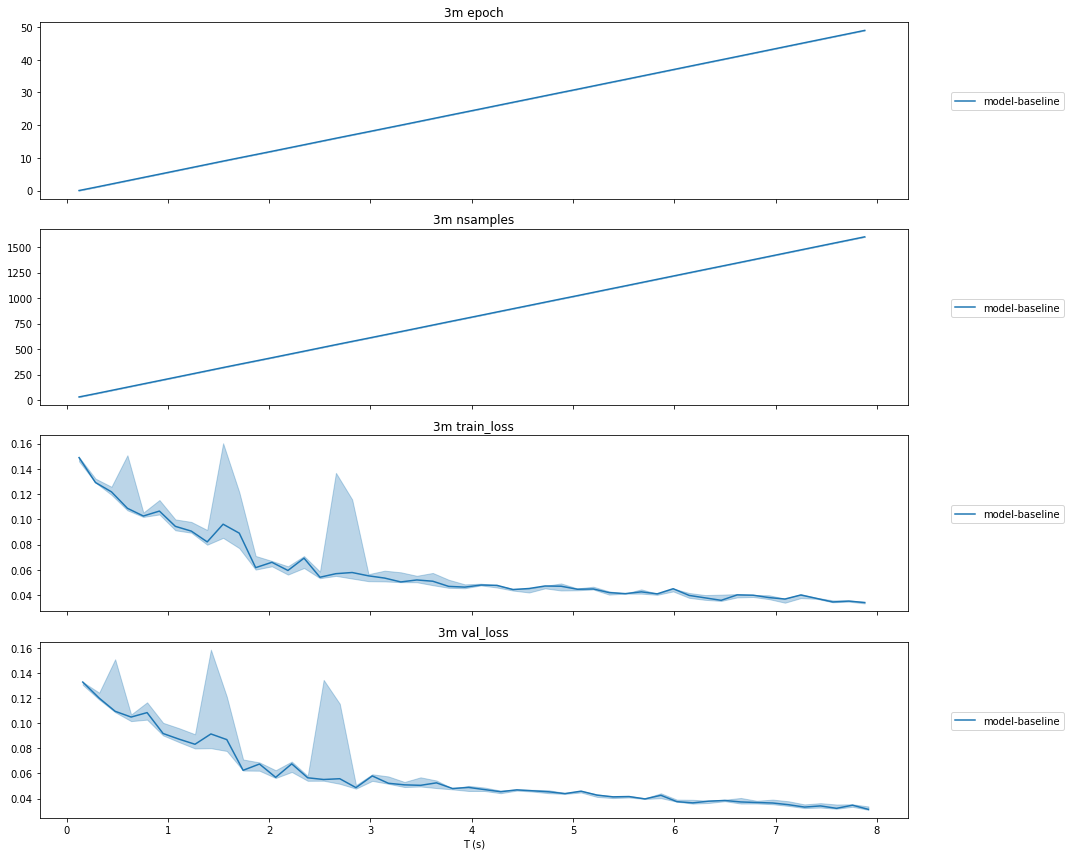

In [74]:
#method = "mean_min_max"
#method = "mean_std"
method = "median_percentile"
selected_keys = [    
    "train_loss",
    "val_loss"
]
selected_keys=None
ylabels = {
    "test_ep_length_mean":"length",        
    "test_return_mean":"return",
    "test_return_std":"return",
    "test_battle_won_mean": "proportion"
}
ylabels={}
fig = plot_group_stats(groups, valid_keys, stats, method, xlabel="T (s)", ylabels=ylabels, selected_keys=selected_keys, 
                       include_bounds=True, title_prefix=map_name)
plt.show()

In [ ]:
# formally compare :
#    shared model vs separate model
#    n full epochs vs n sample based epochs
#    how does model loss vary as the policy improves (use standard QMIX for collection)
#        is it better to periodically reset the network parameters?

In [63]:
# model saving
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
save_model = True
if save_model:
    model_path = "shared-model.pt"
    torch.save(model.state_dict(), model_path)

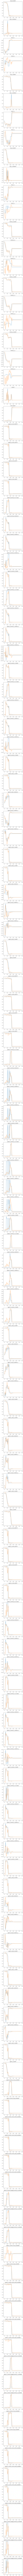

In [80]:
# general plotting
model.eval()
with torch.no_grad():
    props = get_batch(test_episodes, batch_size, use_mask=use_mask)
    state, actions, obs, aa, y = get_input_output(*props)     
    yp, _ = run_model(state.to(device), actions.to(device), obs.to(device), aa.to(device), model, model_output_size)         
    #err = F.mse_loss(yp, y.to(device)).item()
    #print(f"val error: {err:.5f}")

y = y.to('cpu')
yp = yp.to('cpu')

idx = random.choice(range(min(len(test_episodes), batch_size)))
state_scheme = sc.get_state_scheme(custom_features=True)
obs_scheme = sc.get_obs_scheme()
scheme = state_scheme.copy()
n = len(state_scheme)
for k, v in obs_scheme.items():
    scheme[k] = n + v

fig, ax = plt.subplots(len(scheme), figsize=(5, 5 * len(scheme)))
for k, v in scheme.items():    
    i = scheme[k]       
    ax[i].plot(y[idx, :, i], label='actual')
    ax[i].plot(yp[idx, :, i], label='predicted')  
    ax[i].set_title(k)
plt.show()

In [ ]:
# the below has not been updated to work with a shared model

In [77]:
# plotting specific feature
state_model.eval()
use_true_state_val = False
with torch.no_grad():
    props = get_batch(test_episodes, batch_size, use_mask=use_mask)
    state, actions, y = get_state_model_input_output(*props)             
    yp, _ = run_state_model(state.to(device), actions.to(device), state_model, state_model_output_size, use_true_state_val)
    #err = F.mse_loss(yp, y.to(device)).item()
    #print(f"val error: {err:.5f}")
    
y = y.to('cpu')
yp = yp.to('cpu')

idx = random.choice(range(batch_size))
scheme = sc.get_state_scheme(custom_features=True)

feature_name = "reward"
nb = y.size()[0]
ncol = 4
nrow = int(nb / ncol)
fig, ax = plt.subplots(nrow, ncol, figsize=(5 * ncol, 5 * nrow))
f = scheme[feature_name]
for i in range(nrow):
    for j in range(ncol):
        idx = i * ncol + j
        ax[i, j].plot(y[idx, :, f], label='actual')
        ax[i, j].plot(yp[idx, :, f], label='predicted')  
        ax[i, j].set_title(f"{idx}_{feature_name}")
plt.show()

NameError: name 'state_model' is not defined

### Plot Batch

In [134]:
def load_buffer(path):
    b = None
    with open(path, 'rb') as f:
        b = pickle.load(f)
    return b

In [135]:
# pymarl_dir = "../"
# buffer_dir = os.path.join(pymarl_dir, "buffers")
# buffers = glob(os.path.join(buffer_dir, "*.pkl"))
# buffers.sort(key=lambda f: int(os.path.splitext(f.split('_')[1])[0]))
# print(buffers)

In [136]:
def plot_episode(ep):
    state_scheme = sc.get_state_scheme(custom_features=True)
    obs_scheme = sc.get_obs_scheme()
    
    state, action, reward, term_signal, obs, aa, mask = sc.get_episode_vars(ep)
    state = state.cpu()
    reward = reward.cpu()
    term_signal = term_signal.cpu()
        
    # plot state
    fig, ax = plt.subplots(len(state_scheme), figsize=(5, 5 * len(state_scheme)))
    for k, v in state_scheme.items():        
        if k == "reward":
            ax[v].plot(reward[0, :, 0], label='generated')            
        elif k == "term_signal":
            ax[v].plot(term_signal[0, :, 0], label='generated')            
        else:
            ax[v].plot(state[0, :, v], label='generated')
        ax[v].set_title(k)
    plt.show()
    
    # plot obs
    obs_aa = torch.cat((obs, aa), dim=-1).cpu()
    fig, ax = plt.subplots(len(obs_scheme), figsize=(5, 5 * len(obs_scheme)))
    for k, v in obs_scheme.items():
        ax[v].plot(obs_aa[0, :, v], label='generated')
        ax[v].set_title(k)
    plt.show()    

#plot_episode(buffer.sample(32)[0])

def plot_state(ep):
    state_scheme = sc.get_state_scheme(custom_features=True)    
    
    state, action, reward, term_signal, obs, aa, mask = sc.get_episode_vars(ep)
    state = state.cpu()
    reward = reward.cpu()
    term_signal = term_signal.cpu()
        
    # plot state
    fig, ax = plt.subplots(len(state_scheme), figsize=(5, 5 * len(state_scheme)))
    for k, v in state_scheme.items():        
        if k == "reward":
            ax[v].plot(reward[0, :, 0], label='generated')            
        elif k == "term_signal":
            ax[v].plot(term_signal[0, :, 0], label='generated')            
        else:
            ax[v].plot(state[0, :, v], label='generated')
        ax[v].set_title(k)
    plt.show()
    
def plot_obs(ep):
    obs_scheme = sc.get_obs_scheme()    
    
    state, action, reward, term_signal, obs, aa, mask = sc.get_episode_vars(ep)    
    obs_aa = torch.cat((obs, aa), dim=-1).cpu()
    fig, ax = plt.subplots(len(obs_scheme), figsize=(5, 5 * len(obs_scheme)))
    for k, v in obs_scheme.items():
        ax[v].plot(obs_aa[0, :, v], label='generated')
        ax[v].set_title(k)
    plt.show()    

### Generate Batch

In [137]:
from torch.distributions import Categorical
class MAC():
    def select_actions(self, batch, t_ep, bs=slice(None), **kwargs):
        aa = batch["avail_actions"][bs, t_ep]        
        actions = Categorical(aa.float()).sample()
        return actions        
mac = MAC()
#mac.select_actions(batch, t_ep=0, bs=active_episodes)

In [160]:
buffer, ts = load_buffer("../buffer_1024.pkl")
batch_size = 1
episodes = buffer.sample(batch_size)

In [161]:
torch.manual_seed(0)

In [162]:
print(device)

cuda


In [166]:
gen_episodes = []
nbatches = 1

with torch.no_grad():
    for i in range(nbatches):

        # load buffer and create empty batch
        scheme = buffer.scheme.copy()
        scheme.pop("filled", None)
        state_model.eval()
        obs_model.eval()

        batch = partial(EpisodeBatch, scheme, buffer.groups, batch_size, buffer.max_seq_length, preprocess=buffer.preprocess, device=device)()
        bidx = 5

        # get starting state
        state = episodes["state"][:, 0, :state_size].unsqueeze(1).to(device)
        obs = episodes["obs"][:, 0].unsqueeze(1).to(device)
        avail_actions = episodes["avail_actions"][:, 0].unsqueeze(1).to(device)
        actions_onehot = torch.zeros_like(episodes["actions_onehot"][:, 0].view(batch_size, 1, -1)).to(device)            
        term_signal = episodes["terminated"][:, 0].unsqueeze(1).float().to(device)
        terminated = (term_signal > 0)           
        active_episodes = [i for i, finished in enumerate(terminated.flatten()) if not finished]

        n_agents = sc.info["n_agents"] 
        n_actions = scheme["avail_actions"]["vshape"][0]
        obs_feats = scheme["obs"]["vshape"]
        obs_size = n_agents * obs_feats

        o_ht_ct = None
        s_ht_ct = None
        
        max_t = batch.max_seq_length - 1
        for t in range(max_t):

    #         print(f"[{t:01}] active_episodes")
    #         print("   ", active_episodes)        

    #         print(f"[{t:01}] state (excluding action)")
    #         print("   ", state[bidx])    

    #         print(f"[{t:01}] obs")
    #         print("   ", obs[bidx])

    #         print(f"[{t:01}] avail_actions")
    #         print("   ", avail_actions[bidx])

            batch_state = state
            if sc.args.env_args["state_last_action"]:          
                batch_state = torch.cat((state, actions_onehot), dim=-1)            

            pre_transition_data = {
                "state": batch_state[active_episodes],
                "avail_actions": avail_actions[active_episodes],
                "obs": obs[active_episodes]
            }
            batch.update(pre_transition_data, bs=active_episodes, ts=t)          

            aa = batch["avail_actions"][active_episodes, t]
            for i in range(aa.size()[0]):
                try:
                    a = Categorical(aa[i].float()).sample()
                except RuntimeError:
                    print(f"failure on batch index {i} at timestep {t:01}")
                    print(aa[i])   
                    print(avail_actions_raw[i])
                    for k, v in sc.get_state_scheme(custom_features=False).items():
                        print(f"{k}: {state[i, :, v].item():.4f}")                 

            # choose actions following current policy
            actions = mac.select_actions(batch, t_ep=t, bs=active_episodes).unsqueeze(1)
    #         print(f"[{t:01}] actions")
    #         print(actions.squeeze())         

            batch.update({"actions": actions}, bs=active_episodes, ts=t) # this will generate actions_onehot            
            actions_onehot = batch["actions_onehot"][:, t, ...].view(batch_size, 1, -1)  # latest action                   

    #         print(f"[{t:01}] actions_onehot")
    #         print("   ", actions_onehot[bidx])           

            # generate next state, reward and termination signal
            output, s_ht_ct = run_state_model(state, actions_onehot, state_model, state_model_output_size, device, ht_ct=s_ht_ct)
            state = output[:, :, :state_size]; idx = state_size
            reward = output[:, :, idx:idx + reward_size]; idx += reward_size
            term_signal = output[:, :, idx:idx + term_size]  

            # generate termination mask
            threshold = 0.9
            terminated = (term_signal > threshold)
            
            # if this is the last timestep, terminate
            if t == max_t - 1:
                terminated[active_episodes] = True

            #print(f"[{t:01}] terminated")
            #print("   ", terminated.int().flatten())          

            post_transition_data = {
                "reward": reward[active_episodes],
                "terminated": terminated[active_episodes]
            }
            batch.update(post_transition_data, ts=t, bs=active_episodes)        

            # generate new observations
            output, o_ht_ct = run_obs_model(state.to(device), None, obs_model, obs_model_output_size, device, ht_ct=o_ht_ct)
            obs = output[:, 0, :obs_size].view(batch_size, 1, n_agents, obs_feats)
            avail_actions = output[:, 0, obs_size:].view(batch_size, 1, n_agents, n_actions)          
            avail_actions_raw = avail_actions.clone()

            # threshold avail_actions
            threshold = 0.5
            avail_actions = (avail_actions > threshold).float()      

            # handle cases where no agent actions are available
            mask = avail_actions.sum(-1) == 0
            source = torch.zeros_like(avail_actions)
            source[:, :, :, 0] = 1 # enable no-op
            avail_actions[mask] = source[mask]

            # add pre-tranition data to the batch at the next timestep
            pre_transition_data = {
                "state": batch_state[active_episodes],
                "avail_actions": avail_actions[active_episodes],
                "obs": obs[active_episodes]
            }
            batch.update(pre_transition_data, bs=active_episodes, ts=t+1)          
            
            # update active episodes
            active_episodes = [i for i, finished in enumerate(terminated.flatten()) if not finished]
            if all(terminated):
                break            

            #print("\n=================================================\n")
        
        print("done")        
        for i in range(batch_size):
            gen_episodes.append(batch[i])
print(len(gen_episodes))

done
1


In [165]:
terminated.flatten()

tensor([False], device='cuda:0')

In [ ]:
def plot_distributions(key, real, generated, mode="max_t", **kwargs):
    
    # values
    if mode == "max_t":
        real_dist = np.array([ep[key].squeeze().max(0)[1].item() for ep in real])
        gen_dist = np.array([ep[key].squeeze().max(0)[1].item() for ep in generated])
        xlabel = "timestep"
    elif mode == "total":
        real_dist = np.array([ep[key].squeeze().sum().item() for ep in real])
        gen_dist = np.array([ep[key].squeeze().sum().item() for ep in generated])
        xlabel = "value"
    
    # plotting
    real = plt.hist(real_dist, density=True, label="real", **kwargs)
    gen = plt.hist(gen_dist, density=True, label="generated", **kwargs)
    plt.legend()
    plt.title(key)
    plt.xlabel(xlabel)
    plt.ylabel("p density")
    plt.show()    

In [ ]:
real = sc.episodes[:320]

In [ ]:
plot_distributions("reward", real, gen_episodes, mode="total", alpha=0.75, bins=None)

In [ ]:
plot_distributions("terminated", real, gen_episodes, mode="max_t", alpha=0.75, bins=None)

In [ ]:
key="reward"
real = sc.episodes[:320]
ep = sc.episodes[0]
print(ep[key].squeeze().sum().item())
real_dist = np.array([ep[key].squeeze().sum().item() for ep in real])
print(real_dist)

In [ ]:
# what does terminated normally look like for real episodes
real_dist = np.array([ep["terminated"].squeeze().max(0)[1].item() for ep in sc.episodes[:3000]])
gen_dist = np.array([ep["terminated"].squeeze().max(0)[1].item() for ep in gen_episodes[:320]])

In [ ]:
real = plt.hist(real_dist, bins=60, density=True, label="real")
gen = plt.hist(gen_dist, bins=60, density=True, label="generated")
plt.legend()
plt.show()

In [ ]:
gen_dist

In [ ]:
plot_state(gen_episodes[0])

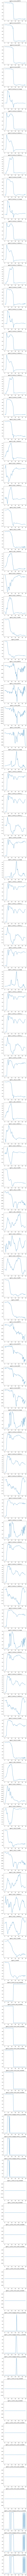

In [212]:
plot_obs(gen_episodes[0])

In [ ]:
ep = batch

# per-agent quantities
obs = ep["obs"][:, :-1, :] # observations
aa = ep["avail_actions"][:, :-1, :].float() # available actions                      
#actions = ep["actions_onehot"][:, :-1, :] # actions taken

# flatten per-agent quantities
nbatch, ntimesteps, _ , _ = obs.size()        
obs = obs.view((nbatch, ntimesteps, -1))        
aa = aa.view((nbatch, ntimesteps, -1))                   
#actions = actions.view(nbatch, ntimesteps, -1)        

# state
#state = ep["state"][:, :-1, :]
#if self.env.state_last_action:
#    state = state[:, :, :self.get_min_state_size()]

# reward
#reward = ep["reward"][:, :-1, :]

# termination signal
#terminated = ep["terminated"][:, :-1].float()                                        
#term_idx = torch.squeeze(terminated).max(0)[1].item()        
#term_signal = torch.ones_like(terminated)        
#term_signal[:, :term_idx, :] = 0         

# mask for active timesteps (except for term_signal which is always valid)
#mask = torch.ones_like(terminated)
#mask[:, term_idx+1:, :] = 0          

#obs *= mask
#aa *= mask        
#actions *= mask
#reward *= mask
#state *= mask

In [ ]:
# plot obs
idx = random.choice(range(batch_size))
obs_scheme = sc.get_obs_scheme()

obs_aa = torch.cat((obs, aa), dim=-1).cpu()
fig, ax = plt.subplots(len(obs_scheme), figsize=(5, 5 * len(obs_scheme)))
for k, v in obs_scheme.items():
    ax[v].plot(obs_aa[idx, :, v], label='generated')
    ax[v].set_title(k)
plt.show()  

In [ ]:
ep = buffer.sample(32)
ep["actions"].squeeze().size()

In [239]:
batch.batch_size

32